<a href="https://colab.research.google.com/github/Depdx/INF8250AE--Reinforcement-Learning/blob/main/INF8250AE_Assignment_1_2083544.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment 1

## Instructions:
* This is an individual assignment. You are not allowed to discuss the problems with other students.
* Part of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want.
* All your solution, code, analysis, graphs, explanations should be done in this same notebook.
* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.
* If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.


**When Submitting to GradeScope**: Be sure to
1) Submit a `.ipynb` notebook to the `Assignment 1 - Code` section on Gradescope.
2) Submit a `pdf` version of the notebook to the `Assignment 1 - Report` entry and tag the answers.

**Note**: You can choose to submit responses in either English or French.

Before starting the assignment, make sure that you have downloaded all the tests related for the assignment and put them in the appropriate locations. If you run the next cell, we will set this all up automatically for you in a dataset called public, which will contain both the data and tests you use.

This assignment has only one question. In this question, you will learn:

1. To understand how to formalize a dose finding study as a multi-arm bandit problem.
2. To implement **$\epsilon$-greedy**, **UCB**, **Boltzmann**, and **Gradient bandit** algorithms.
3. Understand the role of different hyper-parameters.


In [2]:
!pip install -q otter-grader
!git clone https://github.com/chandar-lab/INF8250ae-assignments-2023.git public

'rm' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'public' already exists and is not an empty directory.


In [3]:
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/a1/tests')

In [31]:
import numpy as np
from random import choice, randint
from scipy.stats import bernoulli
from typing import Sequence, Tuple
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(8953)
import warnings
warnings.filterwarnings('ignore')

## Q1: Dose Finding Study (90 points)

In the context of clinical trials, Phase I trials are the first stage of testing in human subjects. Their goal is to evaluate the safety (and feasibility) of the treatment and identify its side effects. The aim of a phase I dose-finding study is to determine the most appropriate dose level that should be used in further phases of the clinical trials. Traditionally, the focus is on determining the highest dose with acceptable toxicity called the Maximum Tolerated Dose (MTD).

A dose-finding study involves a number K of dose levels that have been chosen by physicians based on preliminary experiments (K is usually a number between 3 and 10). Denoting by $p_k$ the (unknown) toxicity probability of dose $k$, the Maximum Tolerated Dose (MTD) is defined as the dose with a toxicity probability closest to a target:

\begin{align}
k^* \in \underset{k\in\{1,\dots,K\}}{\mathrm{argmin}}|\theta - p_k|
\end{align}

where $\theta$ is the pre-specified targeted toxicity probability (typically between 0.2 and 0.35).
A MTD identification algorithm proceeds sequentially: at round $t$ a dose $D_t \in \{1, \dots , K\}$ is selected and administered to a patient for whom a toxicity response is observed. A binary outcome $X_t$ is revealed where $X_t = 1$ indicates that a harmful side-effect occurred and $X_t = 0$ indicates than no harmful side-effect occurred. We assume that $X_t$ is drawn from a Bernoulli distribution with mean $p_{D_t}$ and is independent from previous observations.

**Hint**: In this example, the reward definition is a bit different from the usual case. We would like to take the arm with minimum $|\theta - \hat{p}_k|$ where $\hat{p}_k$ is the estimated toxicity probability.

### Q1.a: Define your Bandit class (5 points):

Most of the class has been written. Complete the pull method in such a way that:

**1.** Update both `num_dose_selected` and `num_toxic` arrays,

**2.** Compute and return the reward $-|\theta - \hat{p}_k|$ where $\hat{p}_k$ is the estimated toxicity probability of arm $k$.

In [68]:
class Bandit(object):

  def __init__(self,
               n_arm: int = 2,
               n_pulls: int = 2000,
               actual_toxicity_prob: list = [0.4, 0.6],
               theta: float = 0.3,
               ):
    self.n_arm = n_arm
    self.n_pulls = n_pulls
    self.actual_toxicity_prob = actual_toxicity_prob
    self.theta = theta
    # ----------------------------------------------
    self.a_star = np.argmax([-abs(theta - p) for p in actual_toxicity_prob])
    self.q_a_star = -abs(theta - actual_toxicity_prob[self.a_star])
    # ----------------------------------------------
    self.init_bandit()

  def init_bandit(self):
    """
        Initialize the bandit
    """
    self.num_dose_selected = np.array([0]*self.n_arm) # number of times a dose is selected
    self.num_toxic = np.array([0]*self.n_arm) # number of times a does found to be toxic

  def pull(self, a_idx: int):
    """
    .inputs:
      a_idx: Index of action.
    .outputs:
      rew: reward value.
    """
    assert a_idx < self.n_arm, "invalid action index"
    # ----------------------------------------------
    self.num_dose_selected[a_idx] = self.num_dose_selected[a_idx] + 1
    is_toxic = bernoulli.rvs(self.actual_toxicity_prob[a_idx])
    self.num_toxic[a_idx] = self.num_toxic[a_idx] + is_toxic
    p_hat = self.num_toxic[a_idx]/self.num_dose_selected[a_idx]
    rew = -abs(self.theta - p_hat)
    # ----------------------------------------------
    return rew

In [69]:
grader.check("q1a")

q1.a results: All test cases passed!

### Dose finding study with three doses

Let's define a dose finding study with three doses ($K = 3$) where you need to choose from with `actual_toxicity_prob=[0.1, 0.35, 0.8]` and targeted toxicity probability is $\theta = 0.3$.

In [70]:
#@title Problem definition
bandit = Bandit(n_arm=3, n_pulls=2000, actual_toxicity_prob=[0.1, 0.35, 0.8], theta=0.3)

### Q1.b: $\epsilon$-greedy for k-armed bandit and Optimistic initial values (25 points)

#### Q1.b1: $\epsilon$-greedy algorithm implementation (5 points)

Implement the $\epsilon$-greedy method.

In [93]:
def eps_greedy(
    bandit: Bandit,
    eps: float,
    init_q: float = .0
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    eps: The epsilon value.
    init_q: Initial estimation of each arm's value.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # initialize q values
  q = np.array([init_q]*bandit.n_arm, dtype=float)

  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []

  for t in range(bandit.n_pulls):
    # ----------------------------------------------
    explore = np.random.binomial(1, eps)
    a:int = None
    if explore:
      a = randint(0, len(q)-1)
    else:
      a = np.argmax(q)

    rew = bandit.pull(a)
    q[a] = q[a] + (rew - q[a]) / (bandit.num_dose_selected[a])
    rew_record.append(rew)
    ret += rew
    avg_ret_record.append(ret / (t+1))

    tot_regret = (t+1) * bandit.q_a_star - ret
    tot_reg_record.append(tot_regret)

    opt_action_perc = np.sum(bandit.num_dose_selected[bandit.a_star])/np.sum(bandit.num_dose_selected)
    opt_action_perc_record.append(opt_action_perc)
    # ----------------------------------------------

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record


In [94]:
grader.check("q1b1")

q1.b1 results:
    q1.b1 - 1 result:
        ❌ Test case failed
        Error at line 15 in test q1.b1:
                  np.testing.assert_allclose(tot_reg_rec_n[-1],730,atol=20)
        AssertionError: 
        Not equal to tolerance rtol=1e-07, atol=20

        Mismatched elements: 1 / 1 (100%)
        Max absolute difference: 594.
        Max relative difference: 0.81369863
         x: array(136.)
         y: array(730)

<!-- BEGIN QUESTION -->

#### Q1.b2: Plotting the results (5 points)

Use the driver code provided to plot: (1) The average return, (2) The reward, (3) the total regret, and (4) the percentage of optimal action across the $N$=20 runs as a function of the number of pulls (2000 pulls for each run) for all three $\epsilon$ values of 0.5, 0.1, and 0.

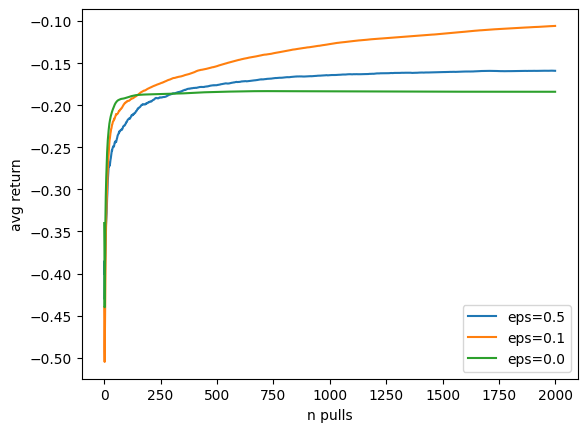

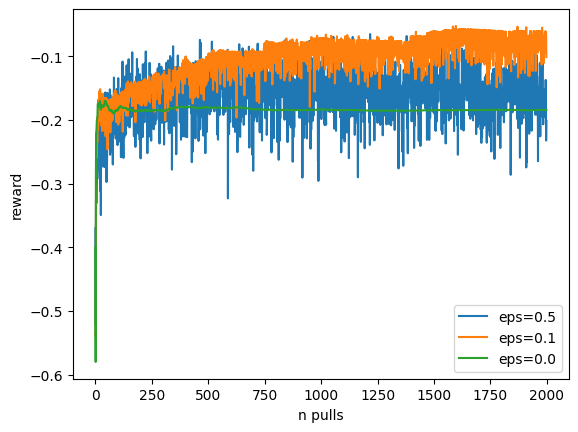

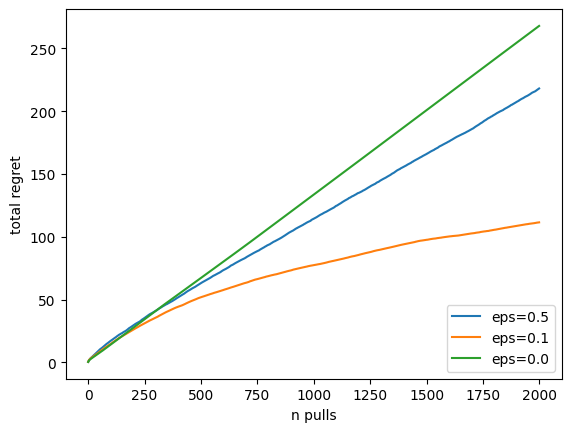

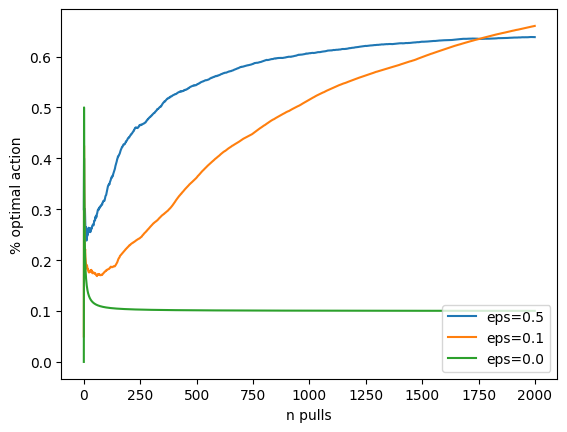

In [89]:
import time
plt.figure(0)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(1)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(2)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(3)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8

for eps in [0.5, 0.1, .0]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)
  start_time = time.time()
  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = eps_greedy(bandit, eps)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)

  end_time = time.time()
  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(0)
  plt.plot(avg_ret_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(1)
  plt.plot(rew_rec[1:], label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(2)
  plt.plot(tot_reg_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(3)
  plt.plot(opt_act_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")


  if tot_reg_rec[-1] < tot_reg_rec_best:
        ep_greedy_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.b3: Analysis (5 points)


Explain the results from the perspective of exploration and how different $\epsilon$ values affect the results.


Type your answer here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Q1.b4: Optimistic Initial Values (5 points)
We want to run the optimistic initial value method on the same problem described above for the initial q values of -1 and +1 for all arms. Compare its performance, measured by the average reward across $N$=20 runs as a function of the number of pulls, with the non-optimistic setting with initial q values of 0 for all arms. For both optimistic and non-optimistic settings, $\epsilon$=0.

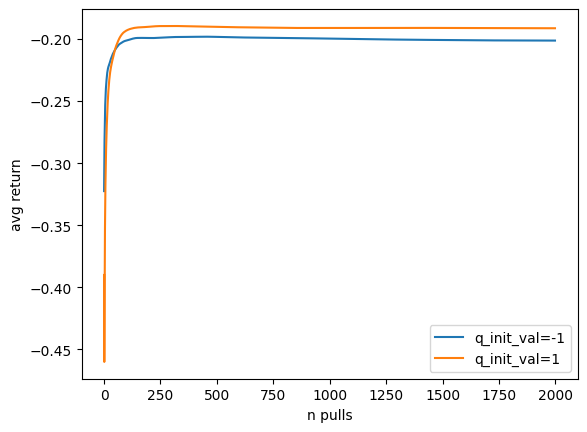

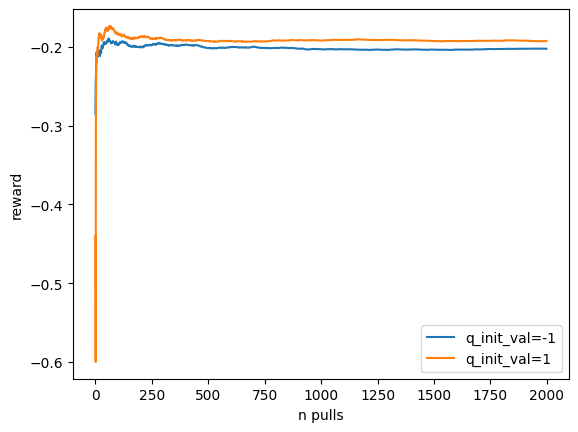

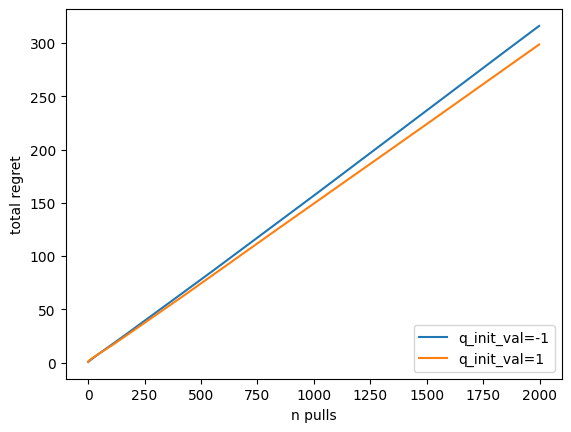

In [90]:
plt.figure(4)
plt.xlabel("n pulls")
plt.ylabel("avg return")

plt.figure(5)
plt.xlabel("n pulls")
plt.ylabel("reward")

plt.figure(6)
plt.xlabel("n pulls")
plt.ylabel("total regret")

N = 20
for init_q in [-1, 1]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = eps_greedy(bandit, eps=0.0, init_q=init_q)

    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)

  avg_ret_rec /= N
  rew_rec /= N
  tot_reg_rec /= N
  plt.figure(4)
  plt.plot(avg_ret_rec[1:], label="q_init_val={}".format(init_q))
  plt.legend(loc="lower right")

  plt.figure(5)
  plt.plot(rew_rec[1:], label="q_init_val={}".format(init_q))
  plt.legend(loc="lower right")

  plt.figure(6)
  plt.plot(tot_reg_rec[1:], label="q_init_val={}".format(init_q))
  plt.legend(loc="lower right")

#### Q1.b5: Analysis (5 points)

Explain how initial q values affect the exploration and the performance.

Type your answer here

<!-- END QUESTION -->

### Q1.c: Upper-Confidence-Bound action selection (15 points)

#### Q1.c1: UCB algorithm implementation (5 points)
Implement the UCB algorithm on the same MAB problem as above.

In [96]:
def ucb(
    bandit: Bandit,
    c: float,
    init_q: float = .0
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    c: The additional term coefficient.
    init_q: Initial estimation of each arm's value.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average summation of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # init q values (the estimates)
  q = np.array([init_q]*bandit.n_arm, dtype=float)

  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []

  for t in range(bandit.n_pulls):
    # Assuming to take the first arm always when there is no exploration
    # ----------------------------------------------
    ucb = []
    for a in range(bandit.n_arm):
        if bandit.num_dose_selected[a] == 0:
            ucb.append(float('inf'))
        else:
            ucb.append(q[a] + c * np.sqrt(np.log(t+1) / (bandit.num_dose_selected[a])))

    a = np.argmax(ucb)

    rew = bandit.pull(a)
    q[a] = q[a] + (rew - q[a]) / (bandit.num_dose_selected[a])
    rew_record.append(rew)
    ret += rew
    avg_ret_record.append(ret / (t+1))

    tot_regret = (t+1) * bandit.q_a_star - ret
    tot_reg_record.append(tot_regret)

    opt_action_perc = np.sum(bandit.num_dose_selected[bandit.a_star])/np.sum(bandit.num_dose_selected)
    opt_action_perc_record.append(opt_action_perc)
    # ----------------------------------------------

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record

In [97]:
grader.check("q1c1")

q1.c1 results:
    q1.c1 - 1 result:
        ❌ Test case failed
        Error at line 14 in test q1.c1:
                  np.testing.assert_allclose(tot_reg_rec_n[-1],700, atol=30)
        AssertionError: 
        Not equal to tolerance rtol=1e-07, atol=30

        Mismatched elements: 1 / 1 (100%)
        Max absolute difference: 608.4
        Max relative difference: 0.86914286
         x: array(91.6)
         y: array(700)

#### Q1.c2: Plotting the results (5 points)

Use the driver code provided to plot: (1) The average return, (2) The reward, (3) the total regret, and (4) the percentage of optimal action across the $N$=20 runs as a function of the number of pulls (2000 pulls for each run) for three values of $c$=0, 0.5, and 2.0.

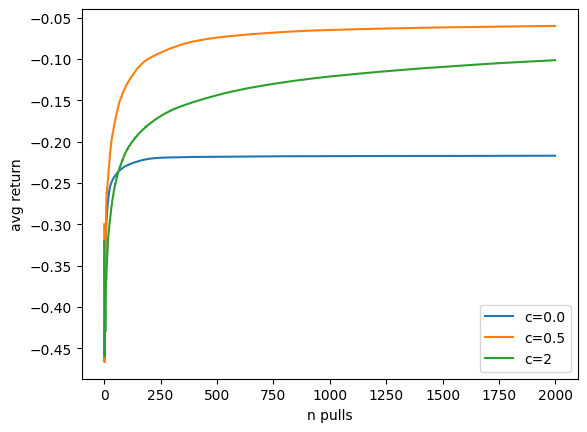

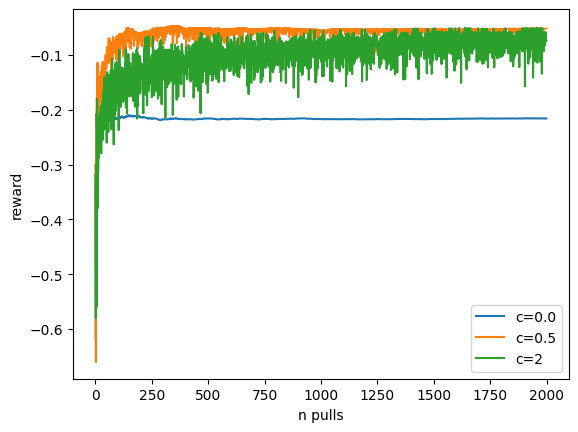

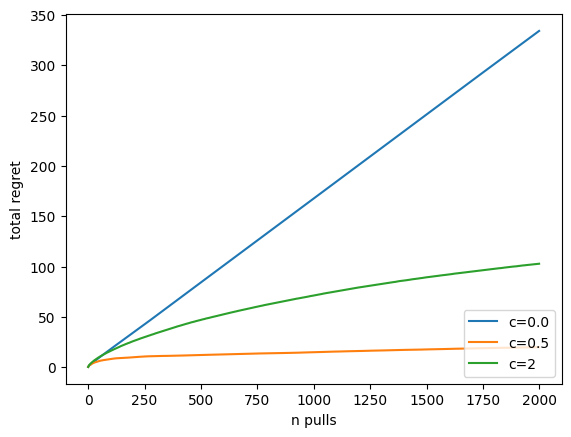

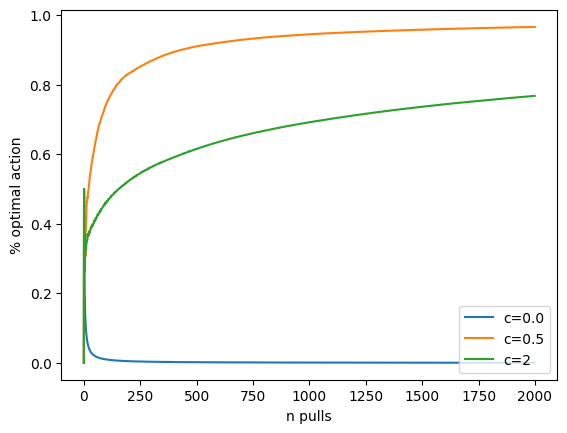

In [98]:
plt.figure(7)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(8)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(9)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(10)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for c in [.0, 0.5, 2]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = ucb(bandit, c)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)

  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(7)
  plt.plot(avg_ret_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(8)
  plt.plot(rew_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(9)
  plt.plot(tot_reg_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(10)
  plt.plot(opt_act_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        ucb_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.c3: Analysis (5 points)


 Explain the results from the perspective of exploration and how different $c$ values affect the results.

Type your answer here

### Q1.d: Boltzmann algorithm (20 points)

#### Q1.d1: Boltzmann policy implementation (5 points)

Implement a Boltzmann policy that gets an array and temprature value ($\tau$) and returns an index sampled from the Boltzmann policy.

In [103]:
def boltzmann_policy(x, tau):
    """ Returns softmax probabilities with temperature tau
        Input:  x -- 1-dimensional array
        Output: idx -- chosen index
    """
    # ----------------------------------------------
    x = np.array(x)
    exp_x = np.exp(x/tau)
    p = exp_x / np.sum(exp_x)
    idx = np.random.choice(len(x), p=p)
    # ----------------------------------------------
    return idx

In [104]:
grader.check("q1d1")

q1.d1 results: All test cases passed!

#### Q1.d2: Boltzmann algorithm implementation (5 points)

Evaluate the Boltzmann algorithm on the same MAB problem as above, for three values of the parameters $\tau$: $0.01$, $0.1$, and $1$. Use the driver code provided to plot their performances across $N$=20 runs as a function of the number of pulls.

**Note:** You can use action-value estimates for the Boltzmann distribution.

In [105]:
def boltzmann(
    bandit: Bandit,
    tau: float = 0.1,
    init_q: float = .0
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    tau: The additional term coefficient.
    init_q: Initial estimation of each arm's value.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average summation of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # init q values (the estimates)
  q = np.array([init_q]*bandit.n_arm, dtype=float)

  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []

  for t in range(bandit.n_pulls):
    # ----------------------------------------------
    a = boltzmann_policy(q, tau)

    rew = bandit.pull(a)
    q[a] = q[a] + (rew - q[a]) / (bandit.num_dose_selected[a])
    rew_record.append(rew)
    ret += rew
    avg_ret_record.append(ret / (t+1))

    tot_regret = (t+1) * bandit.q_a_star - ret
    tot_reg_record.append(tot_regret)

    opt_action_perc = np.sum(bandit.num_dose_selected[bandit.a_star])/np.sum(bandit.num_dose_selected)
    opt_action_perc_record.append(opt_action_perc)
    # ----------------------------------------------

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record

In [106]:
grader.check("q1d2")

q1.d2 results:
    q1.d2 - 1 result:
        ❌ Test case failed
        Error at line 14 in test q1.d2:
                  np.testing.assert_allclose(tot_reg_rec_n[-1],730, atol=20)
        AssertionError: 
        Not equal to tolerance rtol=1e-07, atol=20

        Mismatched elements: 1 / 1 (100%)
        Max absolute difference: 581.6
        Max relative difference: 0.79671233
         x: array(148.4)
         y: array(730)

#### Q1.d3: Plotting the results (5 points)

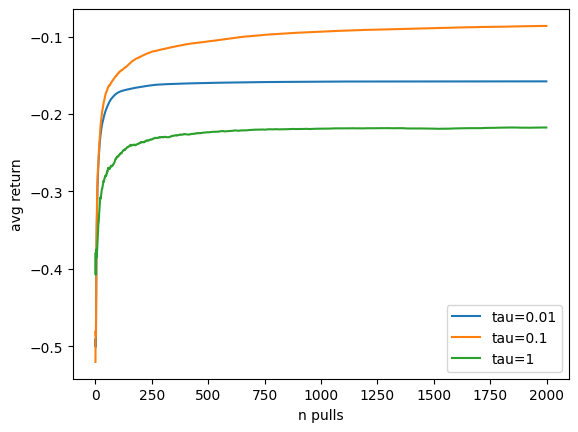

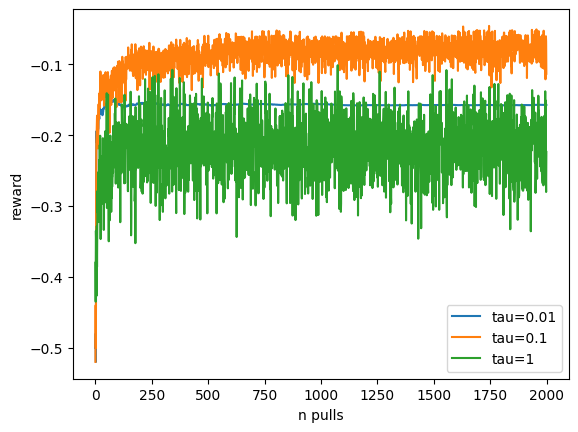

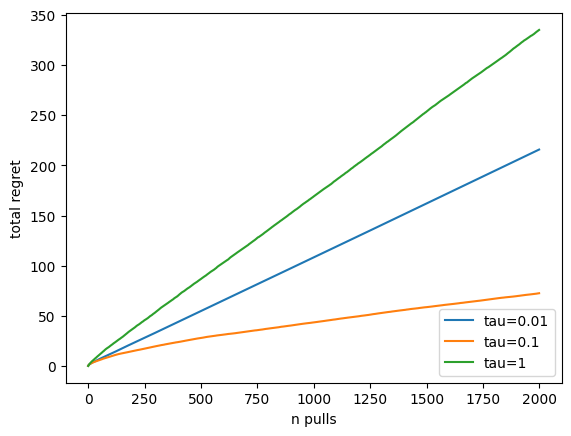

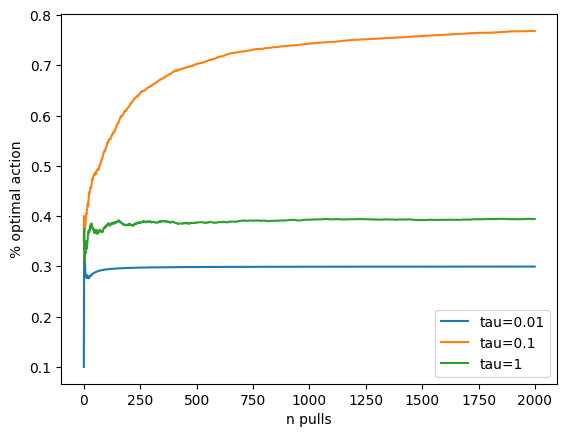

In [107]:
plt.figure(11)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(12)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(13)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(14)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for tau in [0.01, 0.1, 1]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = boltzmann(bandit, tau=tau)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)

  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(11)
  plt.plot(avg_ret_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(12)
  plt.plot(rew_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(13)
  plt.plot(tot_reg_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(14)
  plt.plot(opt_act_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        boltzmann_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.d4: Analysis (5 points)

 Explain the role of $\tau$ paramtere on the results.

Type your answer here

### Q1.f: Gradient Bandits Algorithm (15 points)

#### Q1.f1: GB implementation  (5 points)
Follow the lecture notes to implement the Gradient Bandits algorithm with and without the baseline.

In [108]:
def softmax(x):

    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [118]:
def gradient_bandit(
    bandit: Bandit,
    alpha: float,
    use_baseline: bool = True,
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    alpha: The learning rate.
    use_baseline: Whether or not use avg return as baseline.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average summation of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # init h (the logits)
  h = np.array([0]*bandit.n_arm, dtype=float)

  ret = .0
  r_bar_t = 0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []


  for t in range(bandit.n_pulls):
    # ----------------------------------------------
    p = softmax(h)
    a = np.random.choice(bandit.n_arm, p=p)

    rew = bandit.pull(a)

    if use_baseline:
        r_bar_t = r_bar_t + (rew - r_bar_t) / (t+1)
        for i in range(len(h)):
            if i == a:
                h[a] = h[a] + alpha * (rew - r_bar_t) * p[a] * (1 - p[a])
            else:
                h[i] = h[i] - alpha * (rew - r_bar_t) * p[a] * p[i]
    else:
        for i in range(len(h)):
            if i == a:
                h[a] = h[a] + alpha * rew * p[a] * (1 - p[a])
            else:
                h[i] = h[i] - alpha * rew * p[a] * p[i]

    rew_record.append(rew)
    ret += rew
    avg_ret_record.append(ret / (t+1))

    tot_regret = (t+1) * bandit.q_a_star - ret
    tot_reg_record.append(tot_regret)

    opt_action_perc = np.sum(bandit.num_dose_selected[bandit.a_star])/np.sum(bandit.num_dose_selected)
    opt_action_perc_record.append(opt_action_perc)
    # ----------------------------------------------

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record

In [119]:
grader.check("q1f1")

q1.f1 results:
    q1.f1 - 1 result:
        ❌ Test case failed
        Error at line 14 in test q1.f1:
                  np.testing.assert_allclose(tot_reg_rec_n[-1],740, atol=20)
        AssertionError: 
        Not equal to tolerance rtol=1e-07, atol=20

        Mismatched elements: 1 / 1 (100%)
        Max absolute difference: 605.6
        Max relative difference: 0.81837838
         x: array(134.4)
         y: array(740)

#### Q1.f2: Plotting the results (5 points)

Evaluate the GB algorithm on the same MAB problem as above, for three values of the parameters $\alpha$: $0.05$, $0.1$, and $2$. Use the driver code provided to plot their performances.

**With baseline:**

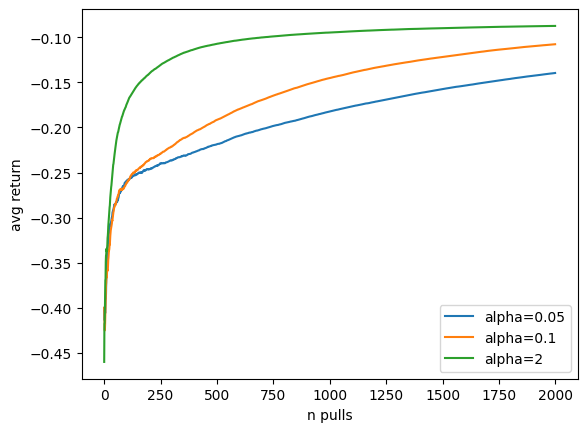

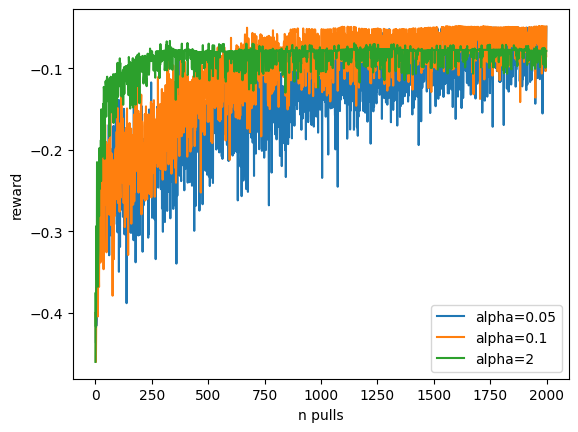

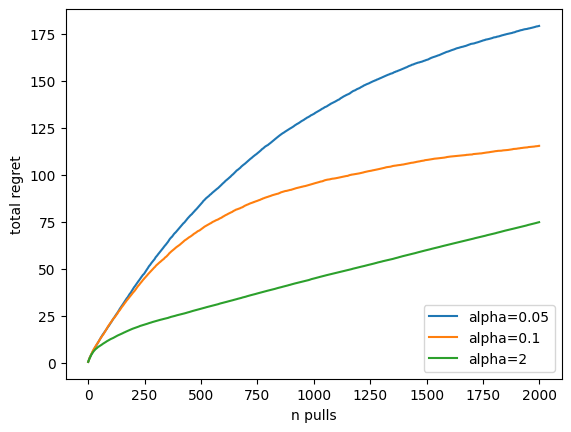

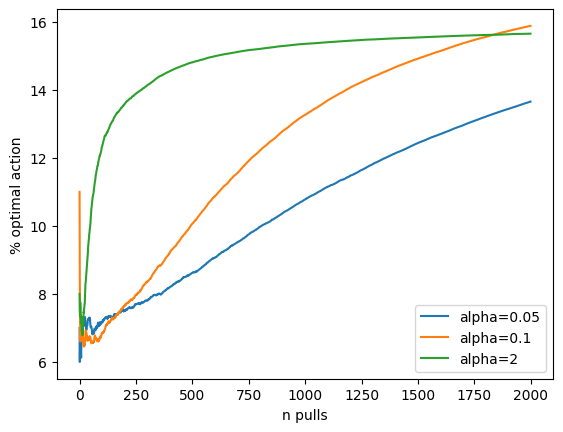

In [120]:
plt.figure(15)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(16)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(17)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(18)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for alpha in [0.05, 0.1, 2]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = gradient_bandit(bandit, alpha=alpha)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)


  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N

  plt.figure(15)
  plt.plot(avg_ret_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(16)
  plt.plot(rew_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(17)
  plt.plot(tot_reg_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(18)
  plt.plot(opt_act_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        gradient_bandit_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

**Without baseline:**

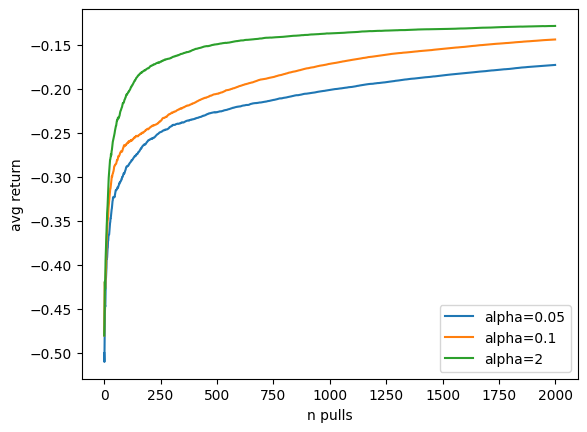

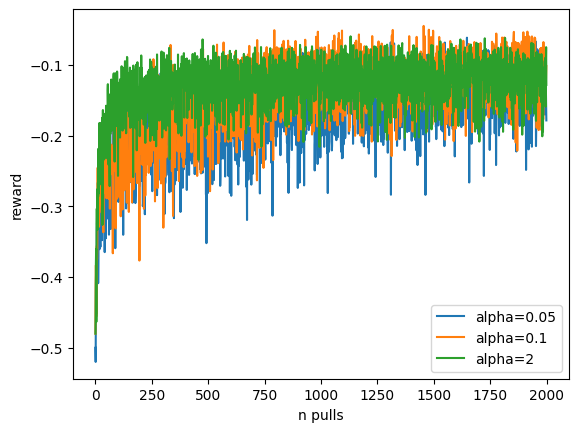

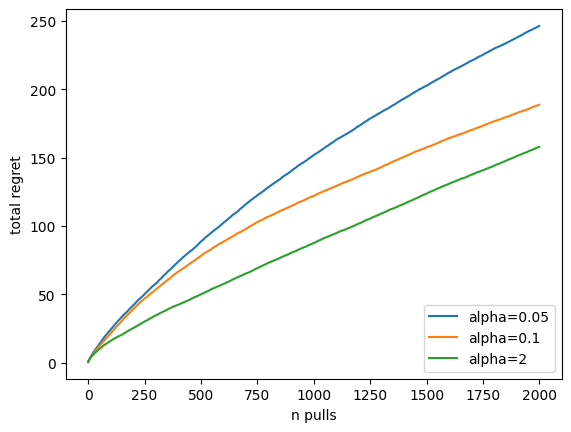

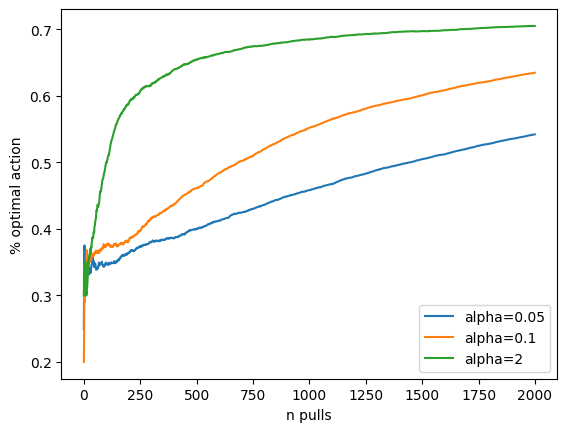

In [121]:
plt.figure(19)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(20)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(21)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(22)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for alpha in [0.05, 0.1, 2]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = gradient_bandit(bandit, alpha=alpha, use_baseline=False)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)


  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(19)
  plt.plot(avg_ret_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(20)
  plt.plot(rew_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(21)
  plt.plot(tot_reg_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(22)
  plt.plot(opt_act_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        gradient_bandit_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.f3: Analysis (5 points)

Explain the role of $\alpha$ and the baseline on the results.

Type your answer here

<!-- BEGIN QUESTION -->

### Q1.g: Final comaprison (10 points)

#### Q1.g1: plots (5 points)
Compare the performance of $\epsilon$-greedy, UCB, Boltzmann algorithm, and Gradient Bandit algorithm in a single plot as measured by the average reward and total regret.

Text(0, 0.5, 'total regret')

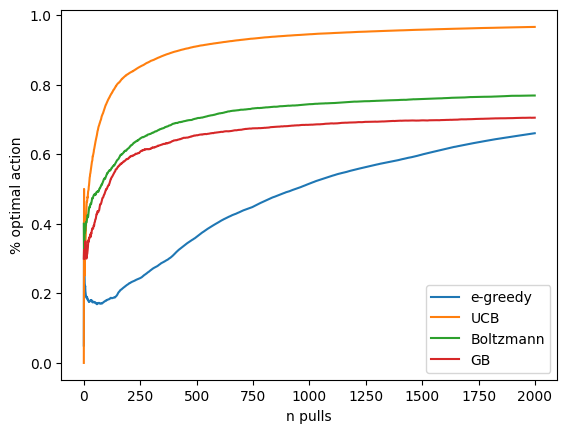

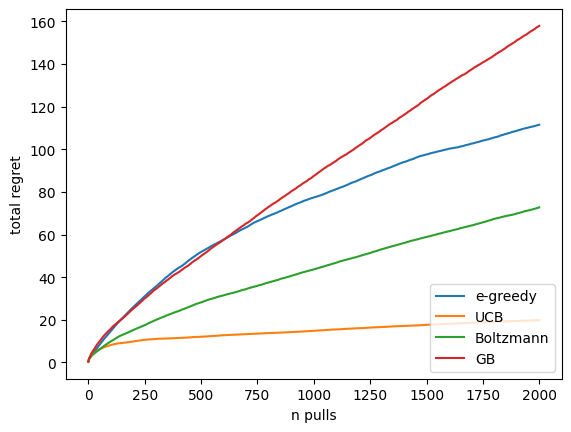

In [122]:
plt.figure(23)
plt.plot(ep_greedy_dict["opt_act"], label="e-greedy")
plt.legend(loc="lower right")
plt.plot(ucb_dict["opt_act"], label="UCB")
plt.legend(loc="lower right")
plt.plot(boltzmann_dict["opt_act"], label="Boltzmann")
plt.legend(loc="lower right")
plt.plot(gradient_bandit_dict["opt_act"], label="GB")
plt.legend(loc="lower right")
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

plt.figure(24)
plt.plot(ep_greedy_dict["regret_list"], label="e-greedy")
plt.legend(loc="lower right")
plt.plot(ucb_dict["regret_list"], label="UCB")
plt.legend(loc="lower right")
plt.plot(boltzmann_dict["regret_list"], label="Boltzmann")
plt.legend(loc="lower right")
plt.plot(gradient_bandit_dict["regret_list"], label="GB")
plt.legend(loc="lower right")
plt.xlabel("n pulls")
plt.ylabel("total regret")

#### Q1.g2: Analysis (5 points)

Compare all the algorithms in terms of their performance.

Type your answer here

In [ ]:
plt.close('all')

<!-- END QUESTION -->

